In [1]:
# # Для работы в колабе раскоменьте эти строки
# !git clone https://github.com/HSE-LAMBDA/DeepGenerativeModels.git
# %cd DeepGenerativeModels/

# Этап 1. Загрузка данных
В данном задании вам предстоит работать с уже знакомым датасетом с лицами и генерировать новые лица с заданными аттрибутами

In [19]:
import sys; sys.path.append('../../utils/')
# from datasets.celeba import CelebADataset
import torch
import torch.nn as nn
import torch.nn.functional as F

from lpips_pytorch.lpips_pytorch import LPIPS
from torchvision import transforms
import gc
from tqdm.auto import trange, tqdm


from typing import Tuple
from os.path import join

import matplotlib.pyplot as plt
import numpy as np

from torch import Tensor

In [3]:
# Spatial size of training images, images are resized to this size.
img_size = 32

# Transformations to be applied to each individual image sample
transform=transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                       std=[0.229, 0.224, 0.225])
    lambda x: x * 2 - 1,
])
inverse_transform = lambda x: (x + 1) / 2

In [4]:
import os
import zipfile 
import gdown
import torch
from natsort import natsorted
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import re
import numpy as np
import torch

class CelebADataset(Dataset):
    def __init__(self, root_dir='/mnt/c/gmdata/celeba', transform=None, attr_index=None):
        """
        Args:
          root_dir (string): Directory with all the images
          transform (callable, optional): transform to be applied to each image sample
        """
        dataset_folder = f'{root_dir}/img_align_celeba/'
        self.dataset_folder = os.path.abspath(dataset_folder)

        image_names = os.listdir(self.dataset_folder)

        self.transform = transform 
        image_names = natsorted(image_names)
        
        filenames = []
        annotations = []
        with open(f'{root_dir}/list_attr_celeba.txt') as f:
            for i, line in enumerate(f.readlines()):
                line = re.sub(' *\n', '', line)
                if i == 0:
                    self.header = re.split(' +', line)
                else:
                    values = re.split(' +', line)
                    filename = values[0]
                    filenames.append(filename)
                    annotations.append([int(v) for v in values[1:]])
        
        annotations = torch.tensor(annotations)    
        
        self.filenames = []
        self.annotations = []
        
        # Обучал на 100'000, сейчас поставил 1000 чтобы не подгружать весь датасет
        # max_size = 100000
        max_size = 1000
        
        if attr_index: 
            self.header = [title for i, title in enumerate(self.header) if i in attr_index]
            
            for filename, annotation in zip(filenames, annotations):
                attr = annotation[attr_index] == 1
                if sum(attr) > 0:
                    self.filenames.append(filename)
                    self.annotations.append(attr)
                
                if len(self.filenames) >= max_size:
                    break
        
        self.images = []
        for i in tqdm(range(len(self))):
            img_name = self.filenames[i]
            img_path = os.path.join(self.dataset_folder, img_name)
            img = Image.open(img_path).convert('RGB')
            
            if self.transform:
                img = self.transform(img)
                
                
            self.images.append(img)     
            
    def __len__(self): 
        return len(self.filenames)

    def __getitem__(self, idx):
        return self.images[idx], self.annotations[idx]

In [5]:
attr_index = [4, 8, 9, 11, 12, 15, 18, 20, 22, 39]

In [6]:
dataset = CelebADataset(attr_index=attr_index, transform=transform)
print('\n'.join(dataset.header))
dataset[0][0].shape, dataset[0][1]

  0%|          | 0/1000 [00:00<?, ?it/s]

Bald
Black_Hair
Blond_Hair
Brown_Hair
Bushy_Eyebrows
Eyeglasses
Heavy_Makeup
Male
Mustache
Young


(torch.Size([3, 32, 32]),
 tensor([False, False, False,  True, False, False,  True, False, False,  True]))

In [7]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, drop_last=True, shuffle=True, num_workers=4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Визуализация датасетов

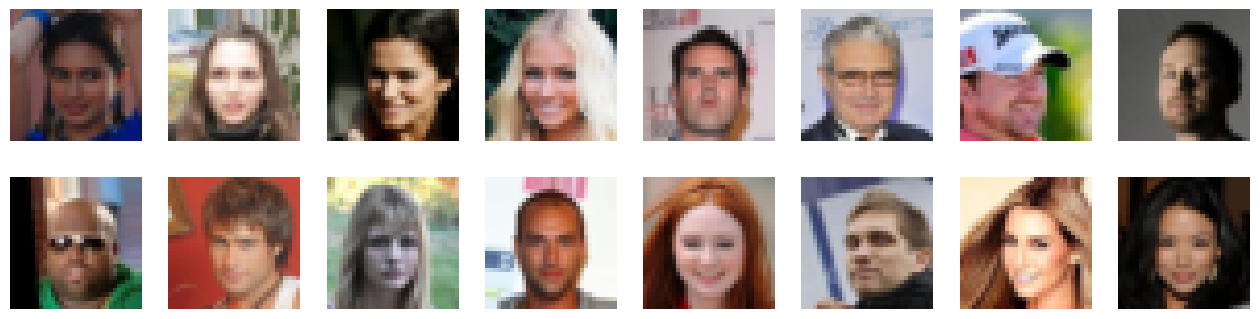

In [8]:
images_cnt = 16
plt.figure(figsize=(images_cnt, 4))
for i, img_idx in enumerate(np.random.choice(range(len(dataset)), images_cnt)):
    img, target = dataset[img_idx]
    # attributes dict for a given image. Contains 40 attributes
    # attributes = {k:v for k,v in zip(dataset.header, target.detach().cpu().numpy())}
    plt.subplot(2, images_cnt // 2,i+1)
    plt.axis("off")
    plt.imshow(inverse_transform(img).detach().cpu().numpy().transpose(1,2,0))

# Этап 2. Обучение модели
В рамках данного задания предлагается реализовать и обучить StarGAN для генережки лиц с заданными аттрибутами
![](assets/stargan.png)

Вам на выбор предлагается реализовать [StarGANv1](https://arxiv.org/pdf/1711.09020.pdf) (**до 4 баллов**) или [StarGANv2](https://arxiv.org/abs/1912.01865) (**до 7 баллов**)

In [9]:
class DBlock(nn.Module):
    def __init__(self, h: int):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(h, 2 * h, 4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(2 * h, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.main(x)


class RBlock(nn.Module):
    def __init__(self, h: int):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(h, h, 3, padding=1, bias=False),
            nn.InstanceNorm2d(h, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(h, h, 3, padding=1, bias=False),
            nn.InstanceNorm2d(h, affine=True, track_running_stats=True),
        )

    def forward(self, x: Tensor) -> Tensor:
        return x + self.main(x)


class UBlock(nn.Module):
    def __init__(self, h: int):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(h, h // 2, 4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(h // 2, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.main(x)


class Generator(nn.Module):
    def __init__(self, h: int = 48, c: int = 10, r: int = 3 + 1, d: int = 2):
        """
        h - hidden layer size param
        c - num domains
        r - num res blocks
        d - num downsample blocks and upsample blocks
        """
        super(Generator, self).__init__()
        
        compute_h = lambda i: (2 ** i) * h
        
        layers = [
            nn.Conv2d(3 + c, h, 7, padding=3, bias=False),               # [b, 3 + c, 64, 64] - [b, h, 64, 64]
            nn.InstanceNorm2d(h, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        ] + [
            DBlock(compute_h(i)) for i in range(d)                       # [b, h, 64, 64] - [b, 2 * h, 32, 32] - [b, h * 4, 16, 16]
        ] + [
            RBlock(compute_h(d)) for _ in range(r)
        ] + [ 
            UBlock(compute_h(d - i)) for i in range(d)                   # [b, h * 4, 16, 16] - [b, 2 * h, 32, 32] - [b, h, 64, 64]
        ] + [
            nn.Conv2d(h, 3, 7, padding=3, bias=False),                   # [b, h, 64, 64] - [b, 3, 64, 64]
            nn.Tanh()
        ]
        
        self.main = nn.Sequential(*layers)

    def forward(self, x: Tensor, c: Tensor) -> Tensor:
        c = c[..., None, None]                     # [b, c, 1, 1]
        c = c.repeat(1, 1, x.shape[2], x.shape[2]) # [b, c, img h, img w]
        x = torch.cat([x, c], dim=1)               # [b, c + 3, img h, img w]
        return self.main(x)                        # [b, 3, img h, img w]

In [10]:
class Discriminator(nn.Module):
    def __init__(self, img_size: int = 32, h: int = 48, c: int = 10, n_blocks: int = 4):
        super().__init__()
        
        layers = [nn.Conv2d(3, h, 4, stride=2, padding=1), nn.LeakyReLU()]
        for _ in range(n_blocks):
            layers += [nn.Conv2d(h, 2 * h, 4, stride=2, padding=1), nn.LeakyReLU()] # [h, 64, 64] - [2 * h, 32, 32] - [h * 4, 16, 16]
            h *= 2

        cur_img_size = img_size // (2 ** (n_blocks + 1))
        
        self.main = nn.Sequential(*layers)
        self.classifier = nn.Conv2d(h, 1, cur_img_size, bias=False)
        self.domain = nn.Conv2d(h, c, cur_img_size, bias=False)

    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        x = self.main(x) 
        cls = self.classifier(x).reshape(x.shape[0], -1) # [bs, 1]
        domains = self.domain(x).reshape(x.shape[0], -1) # [bs, c]
        return cls, domains

In [11]:
def compute_gradient_penalty(cls, x):
    """
    (L2_norm(dy/dx) - 1) ** 2
    """
    weight = torch.ones_like(cls)
    dydx = torch.autograd.grad(
        outputs=cls, 
        inputs=x, 
        grad_outputs=weight, 
        retain_graph=True, 
        create_graph=True, 
        only_inputs=True
    )[0]

    dydx = dydx.view(dydx.size(0), -1)
    dydx_l2norm = torch.sqrt(torch.sum(dydx**2, dim=1))
    result = torch.mean((dydx_l2norm - 1) ** 2)
    
    return result

def _train(
    gen,
    disc,
    n_epochs: int = 3,
    lambda_domains: float = 1,
    lambda_gp: float = 10,
    lambda_rec: float = 10 * 5,
    g_lr: float = 1e-3 / 3,
    d_lr: float = 1e-4 / 3,
    n_critic: int = 2,
    g_lr_decay: float = 0.5,
    d_lr_decay: float = 0.5,
    start_epoch: int = 0,
):
    g_optim = torch.optim.AdamW(gen.parameters(), lr=g_lr)
    g_scheduler = torch.optim.lr_scheduler.ExponentialLR(g_optim, g_lr_decay)
    d_optim = torch.optim.SGD(disc.parameters(), lr=d_lr)
    d_scheduler = torch.optim.lr_scheduler.ExponentialLR(d_optim, d_lr_decay)

    checkpoint_dir = join("checkpoints", '0')

    for e in trange(start_epoch, start_epoch + n_epochs, desc="Epochs"):
        for i, (b_images, b_domains) in tqdm(enumerate(dataloader), "Training", leave=False, total=len(dataloader)):
            b_images, b_domains = b_images.to(device), b_domains.to(device).float()

            b_random_domains = b_domains[torch.randperm(b_domains.shape[0])]

            # Discriminator step
            cls, domains = disc(b_images)
            d_loss_real = -torch.mean(cls)
            d_loss_domains = F.binary_cross_entropy_with_logits(domains, b_domains)

            with torch.no_grad():
                x_fake = gen(b_images, b_random_domains).detach()
            cls, _ = disc(x_fake)
            d_loss_fake = torch.mean(cls)

            # Compute loss for gradient penalty
            alpha = torch.rand(b_images.shape[0], 1, 1, 1).to(device)
            x_hat = (alpha * b_images.data + (1 - alpha) * x_fake.data).requires_grad_(True)
            cls, _ = disc(x_hat)
            d_loss_gp = compute_gradient_penalty(cls, x_hat)

            d_loss = d_loss_real + d_loss_fake + lambda_domains * d_loss_domains + lambda_gp * d_loss_gp

            d_optim.zero_grad()
            d_loss.backward()
            # torch.nn.utils.clip_grad_norm_(disc.parameters(), 1) # ganhack from seminar
            d_optim.step()
            
            # Generator step
            if i % n_critic == 0:
                x_fake = gen(b_images, b_random_domains)
                cls, domains = disc(x_fake)
                g_loss_real = -torch.mean(cls)
                g_loss_domains = F.binary_cross_entropy_with_logits(domains, b_random_domains)

                x_recon = gen(x_fake, b_domains)
                g_loss_recon = F.l1_loss(x_recon, b_images)

                g_loss = g_loss_real + lambda_domains * g_loss_domains + lambda_rec * g_loss_recon

                g_optim.zero_grad()
                g_loss.backward()
                g_optim.step()
            
            # Append losses
            if (i + 1) % 50 == 0:
                losses["epoch"].append(e)
                
                losses['d/lr'].append(d_scheduler.get_last_lr()[0])
                losses["d/classifier_real"].append(d_loss_real.item())
                losses["d/classifier_fake"].append(d_loss_fake.item())
                losses["d/domains"].append(d_loss_domains.item())
                losses["d/gradient_penalty"].append(d_loss_gp.item())
                losses["d/loss"].append(d_loss.item())
                
                losses['g/lr'].append(g_scheduler.get_last_lr()[0])
                losses["g/classifier_real"].append(g_loss_real.item())
                losses["g/domains"].append(g_loss_domains.item())
                losses["g/reconstruction"].append(g_loss_recon.item())
                
                losses["g/loss"].append(g_loss.item())

        g_scheduler.step()
        d_scheduler.step()
        
        torch.save(gen.state_dict(), join(checkpoint_dir, f"generator_epoch_{e}.ckpt"))
        torch.save(disc.state_dict(), join(checkpoint_dir, f"discriminator_epoch_{e}.ckpt"))
                
    return gen, disc

In [12]:
def train(to_train: bool = True, generator_ckpt: str = None, discriminator_ckpt: str = None):
    gen = Generator().to(device)
    disc = Discriminator().to(device)

    if generator_ckpt is not None:
        checkpoint = torch.load(generator_ckpt, map_location=device)
        gen.load_state_dict(checkpoint)
    if discriminator_ckpt is not None:
        checkpoint = torch.load(discriminator_ckpt, map_location=device)
        disc.load_state_dict(checkpoint)
    if to_train:
        gen, disc = _train(gen, disc)

    return gen, disc

In [13]:
losses = {
    "epoch": [],
    "d/lr": [], 
    "d/classifier_real": [], 
    "d/classifier_fake": [],
    "d/domains": [], 
    "d/gradient_penalty": [], 
    "d/loss": [],
    
    "g/lr": [],
    "g/classifier_real": [],
    "g/domains": [],
    "g/reconstruction": [],
    "g/loss": [],
}

In [14]:
GENERATOR_CKPT = "generator.ckpt"

# GENERATOR_CKPT = None
DISCRIMINATOR_CKPT = None

# GENERATOR_CKPT = 'checkpoints/0/generator_epoch_1.ckpt'
# DISCRIMINATOR_CKPT = 'checkpoints/0/discriminator_epoch_1.ckpt'

gen, _ = train(to_train=False, generator_ckpt=GENERATOR_CKPT, discriminator_ckpt=DISCRIMINATOR_CKPT)

In [15]:
def plot_loss(losses):
    keys = ['d/loss', 'g/loss', "d/classifier_real", "d/classifier_fake", "d/domains", "d/gradient_penalty", "g/classifier_real", "g/domains", "g/reconstruction"]
    rows = 3
    
    fig, ax = plt.subplots(len(keys) // rows, rows, figsize=(4 * rows, 4))
    fig.tight_layout()
    for i, key in enumerate(keys):
        plt.subplot(len(keys) // rows, rows, i + 1)
        plt.title(key)
        plt.plot(losses[key])
    plt.show()

# plot_loss(losses)

# Evaluation

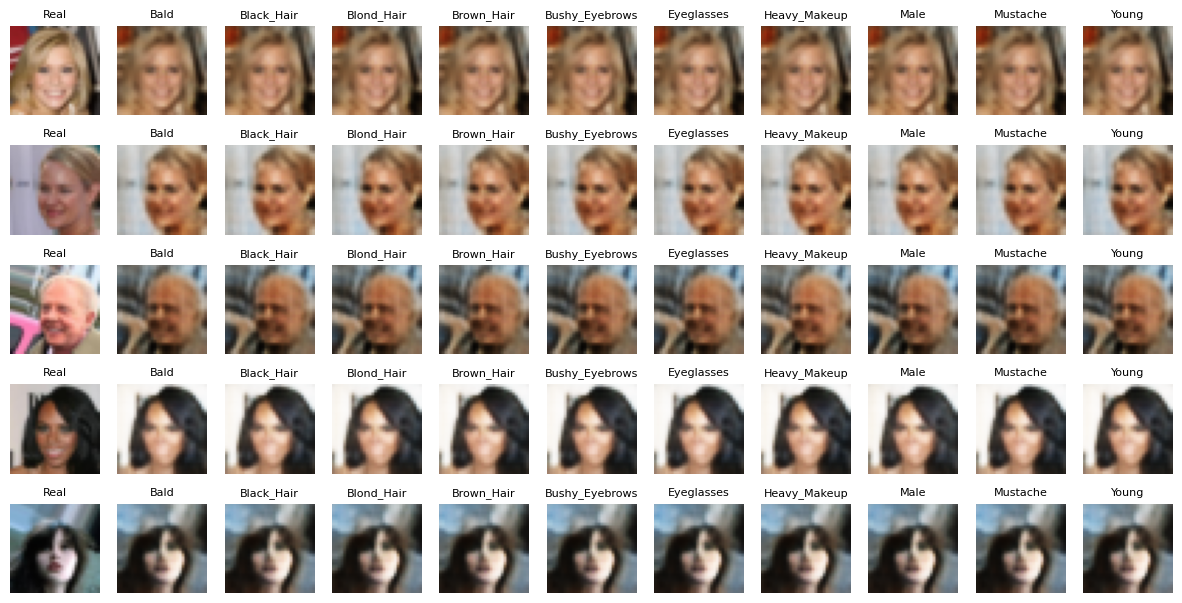

In [23]:
images_number = 5
attrs_number = 10

fig, ax = plt.subplots(images_number, attrs_number + 1, figsize=(1.5 * attrs_number, 1.5 * images_number))

it = iter(dataset)
for i in range(images_number):
    x_real, y_real = dataset[np.random.randint(len(dataset))]
    for j in range(attrs_number + 1):
        if j == 0:
            plt.subplot(images_number, attrs_number + 1, i * (attrs_number + 1) + j + 1)
            plt.title("Real", fontsize=8)
            plt.axis("off")
            plt.imshow(inverse_transform(x_real).detach().cpu().numpy().transpose(1,2,0))
        else:
            y_trg = y_real.clone()
            y_trg[j - 1] = ~y_trg[j - 1]
            with torch.no_grad():
                x_fake = gen(x_real.unsqueeze(0).to(device), y_trg.unsqueeze(0).to(device))
            x_fake = inverse_transform(x_fake[0]).detach().cpu().numpy().transpose(1,2,0)
            
            plt.subplot(images_number, attrs_number + 1, i * (attrs_number + 1) + j + 1)
            plt.title(dataset.header[j - 1], fontsize=8)
            plt.axis("off")
            plt.imshow(x_fake)

In [17]:
lpips = LPIPS()

/home/zalevskiaa/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/zalevskiaa/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
lpips = LPIPS().to(device)

values = []
for x_real, y_real in tqdm(torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=4)):
    x_real, y_real = x_real.to(device), y_real.to(device).float()
    y_trg = y_real.flip(dims=[0])
    with torch.no_grad():
        x_fake = gen(x_real, y_trg)
    values.append(lpips(x_fake, x_real).squeeze().item())
lpips_score = np.mean(values)


lpips_score

  0%|          | 0/1000 [00:00<?, ?it/s]

0.035585706031415615

# Этап 3(\*). Дополнительный анализ

* Анализ латентного пространства и визуально качественный результат - **2 балла**
* Текстовое ревью решения и предложения возможных улучшений - **1 балл**

- Кучу времени игрался с размером сети и параметрами, чаще всего с `lr` , `reconstruction loss lambda`, `domain classification lambda`.  
Ожидал лучшего результата, но всё равно очень понравилось.

- Заменить `Adam` оптимизатор на `SGD` у дискриминатора, как советовали на семинаре и в ганхаках, показалось хорошей идеей.  
Особенно когда увеличивал `lr` у генератора.

- Долго не удавалось сгенерировать что-то отличное от шума :(.  
Потом увеличил `reconstruction loss lambda` и стали получаться более-менее человеческие картинки, но они не зависели от домена.  
Потом увеличивал `domain classification lambda` и получались менее человеческие картинки / картинки с шумом вместо лица / шум вместо картинки.

- Есть ощущение, что рабочим вариантом могло быть сначала научить генератор генерировать просто человеческие картинки, потом научить дискриминатор различать домены, потом научить генератор генерировать человеческие картинки, зависящие от домена.

- Пробовал обучать с двумя доменами, но до состояния "адекватные картинки и зависящие от домена" всё равно не дошёл.  
Не сразу появилась эта идея и хотелось бы чуть больше с ней покопаться, возможно, это бы как-то помогло

- Вот такое ещё сделал наблюдение: если лосс классификации дискриминатора улетел вверх - то генератор скатился в генерацию шума.  
В случаях, когда генератор начинал генерировать шум, не продолжал обучение, хотя, возможно, стоило попробовать

- Ещё очень хотел попробовать поставить чуть больше блоков в генератор и дискриминатор, возможно, тогда это даже было бы проще обучить.